# Modelo multimodal CLIP

Modelos multimodais realizam o processamento de dados de múltiplas modalidades. Veremos especificamente sobre o processamento de texto e imagens, que são os chamados *visual language models*. 

Implementaremos o modelo CLIP, desenvolvido pela OpenAI.

Referências:

* [Learning Transferable Visual Models From Natural Language Supervision](https://arxiv.org/abs/2103.00020)
* [Repositório do Hugginface](https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py)


In [18]:
import torch
from dataset import collate_fn, get_dataset
from torch import nn
from torch.utils.data import DataLoader

ds, _ = get_dataset("../Graphs/data/images", "../Graphs/data/edgelists.json")
dl = DataLoader(ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
imgs, texts = next(iter(dl))

### Extração de atributos de texto

In [19]:
from model import TextEncoder

text_encoder = TextEncoder()
features = text_encoder(texts)
features.shape


Device set to use cpu


torch.Size([8, 768])

### Extração de atributos de imagem

In [20]:
from torchvision.models import ResNet50_Weights, resnet50

image_encoder = resnet50(weights=ResNet50_Weights.DEFAULT)
image_encoder.fc = nn.Identity()
features = image_encoder(imgs)
features.shape

torch.Size([8, 2048])

### Modelo multimodal

Temos um codificador de imagens que extrai 2048 atributos para cada imagem de entrada e um codificador de texto que extrai 768 atributos para cada texto. Criaremos um modelo que calcula a similaridade entre esses atributos. 

In [21]:
class Clip(nn.Module):

    def __init__(self, image_encoder, text_encoder, img_dim, text_dim,
                 temp=2.6592, dim=512):
        super().__init__()

        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        # Camadas de projeção
        self.visual_projection = nn.Linear(img_dim, dim, bias=False)
        self.text_projection = nn.Linear(text_dim, dim, bias=False)
        # Parâmetro treinável responsável por reescalar os valores de similaridade
        self.logit_scale = nn.Parameter(torch.tensor(temp)) 

    def project_images(self, imgs):
        """Codifica imagens."""

        image_embeds = self.image_encoder(imgs)
        image_embeds = self.visual_projection(image_embeds)
        # Normaliza os valores pela magnitude do vetor, que é a raiz quadrada 
        # da soma dos valores ao quadrado
        image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)

        return image_embeds
    
    def project_texts(self, texts):
        """Codifica textos."""

        text_embeds = self.text_encoder(texts)
        text_embeds = self.text_projection(text_embeds)
        text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)

        return text_embeds

    def forward(self, imgs, texts, return_emb=False):

        image_embeds = self.project_images(imgs)
        text_embeds = self.project_texts(texts)
        
        logit_scale = self.logit_scale.exp()

        # Similaridade de coseno. Cada linha i dessa matriz representa a 
        # similaridade entre o texto i e as imagens do batch. O elemento
        # (i,i) representa a similaridade entre o texto i e a imagem correta 
        # que corresponde a esse texto, enquanto que os demais elementos da 
        # linha correspondem a correspondências incorretas. 
        # text_embeds: bs x dim
        # image_embeds.t(): dim x 
        # logits_per_text: bs x bs
        logits_per_text = torch.matmul(text_embeds, image_embeds.t()) * logit_scale

        output = logits_per_text
        # Opcionalmente, retorna as projeções das imagens e textos
        if return_emb:
            output += (image_embeds, text_embeds)

        return output
    
def contrastive_loss(logits_per_text):
    """Calcula a entropia cruzada para cada linha da matriz, considerando
    que a "classe" correta da linha i é dada pela coluna i."""

    scores = logits_per_text
    targets = torch.arange(len(logits_per_text), device=logits_per_text.device)
    loss = nn.functional.cross_entropy(scores, targets)

    return loss

def clip_loss(logits_per_text):
    """Queremos que a matriz de similaridade possua valores altos na diagonal,
    e valores baixos fora da diagonal. Essa loss também é chamada de InfoNCE."""

    caption_loss = contrastive_loss(logits_per_text)
    image_loss = contrastive_loss(logits_per_text.t())
    return (caption_loss + image_loss) / 2.0

# Se quisermos evitar de treinar o encoder de texto, podemos desabilitar
# os gradientes
text_encoder.requires_grad_(False)
model = Clip(image_encoder, text_encoder, img_dim=2048, text_dim=768)

logits_per_text = model(imgs, texts)
loss = clip_loss(logits_per_text)
loss

tensor(2.1297, grad_fn=<DivBackward0>)

In [22]:
def similarity(model, image, enc_texts, device="cpu"):
    model.eval()
    with torch.no_grad():
        # imagem
        img_emb = model.project_images(image.to(device))
        
        # textos já tokenizados
        text_embs = model.project_texts(enc_texts)
        
        sim = torch.matmul(img_emb, text_embs.T).squeeze(0)
    return sim


In [23]:
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# exemplo: BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# texts vem do DataLoader como lista de strings
enc_texts = tokenizer(list(texts), padding=True, truncation=True, return_tensors="pt")

# agora sim é um batch de tensores
text_batch = enc_texts["input_ids"].to(device)
attn_mask = enc_texts["attention_mask"].to(device)

In [24]:

images = imgs.to(device)              # (B, C, H, W)
sims = similarity(model, images, list(texts), device)

print("Similaridades:", sims.tolist())


Similaridades: [[-0.012666369788348675, -0.011128599755465984, -0.007978321053087711, -0.01196405291557312, -0.010771308094263077, -0.01175820454955101, -0.009752622805535793, -0.010469915345311165], [-0.00991005264222622, -0.0074161384254693985, -0.004044439643621445, -0.007238160818815231, -0.008356094360351562, -0.010100672021508217, -0.005526036024093628, -0.006354104727506638], [-0.002905959263443947, -0.0010158028453588486, 0.002450069412589073, -0.0005494598299264908, -0.0013417433947324753, -0.0032324939966201782, 0.001067284494638443, 0.0005676504224538803], [0.0017847195267677307, 0.005317231640219688, 0.007028795778751373, 0.0029055997729301453, 0.003907652571797371, 0.0029130512848496437, 0.005633293651044369, 0.004386892542243004], [0.002669908106327057, 0.00487726554274559, 0.007963502779603004, 0.0028476249426603317, 0.0048059336841106415, 0.0033064335584640503, 0.005442426539957523, 0.0046879928559064865], [-0.005537904798984528, -0.0020230035297572613, 0.00042982120066

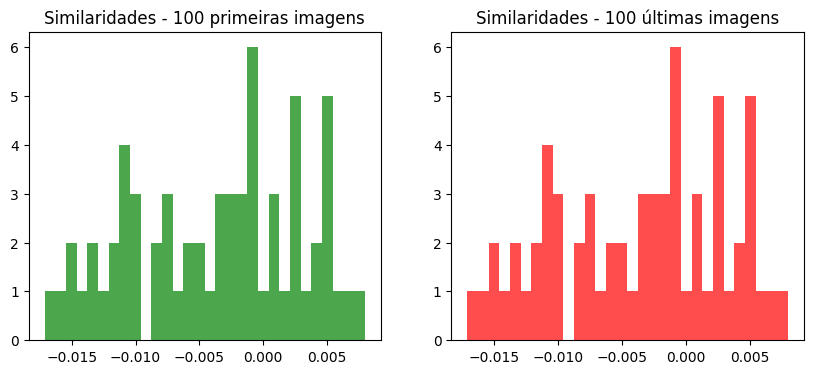

In [35]:
import matplotlib.pyplot as plt
import torch

# supondo que sims seja (num_images, num_texts)

# primeiras 100 imagens
sims_first100 = sims[:100].reshape(-1)   # pega linhas 0–99
# últimas 100 imagens
sims_last100 = sims[-100:].reshape(-1)   # pega linhas finais

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(sims_first100.cpu().numpy(), bins=30, color="green", alpha=0.7)
plt.title("Similaridades - 100 primeiras imagens")

plt.subplot(1,2,2)
plt.hist(sims_last100.cpu().numpy(), bins=30, color="red", alpha=0.7)
plt.title("Similaridades - 100 últimas imagens")

plt.show()


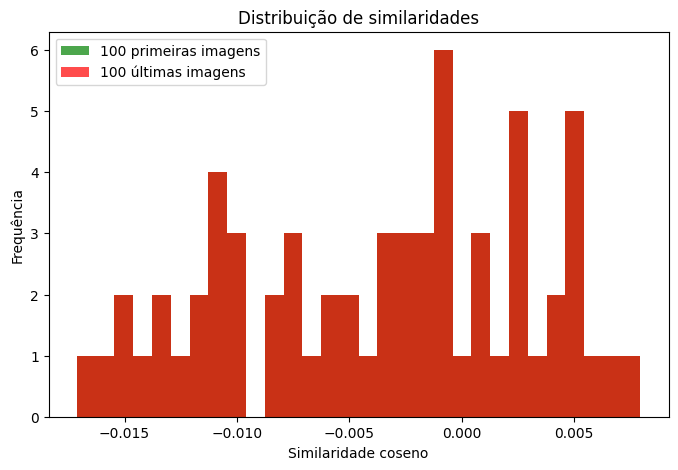

In [39]:
import matplotlib.pyplot as plt
import torch

# supondo que sims seja (num_images, num_texts)

# primeiras 100 imagens
sims_first100 = sims[:100].reshape(-1)   # linhas 0–99 achatadas
# últimas 100 imagens
sims_last100 = sims[-100:].reshape(-1)   # últimas 100 linhas achatadas

plt.figure(figsize=(8,5))

plt.hist(sims_first100.cpu().numpy(), bins=30, alpha=0.7, color="green", label="100 primeiras imagens")
plt.hist(sims_last100.cpu().numpy(), bins=30, alpha=0.7, color="red", label="100 últimas imagens")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades")
plt.legend()
plt.show()


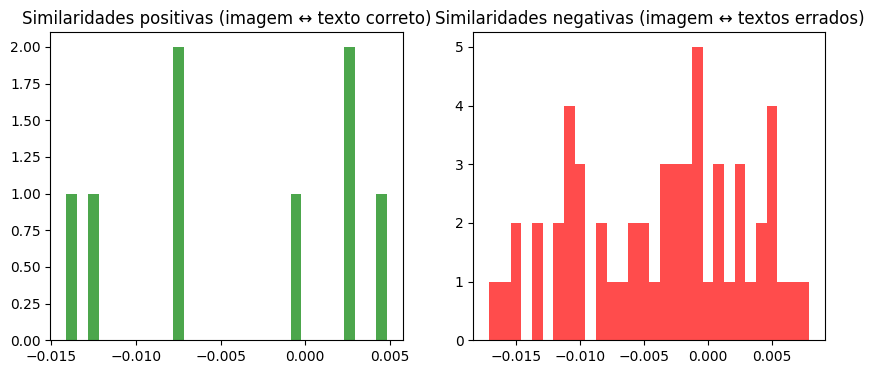

In [28]:
import matplotlib.pyplot as plt
import torch

# sims: (num_images, num_texts)

# pega a diagonal -> imagem i com texto i
positives = sims.diag().cpu().numpy()

# pega tudo fora da diagonal -> negativos
mask = ~torch.eye(sims.size(0), dtype=bool, device=sims.device)
negatives = sims[mask].cpu().numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(positives, bins=30, color="green", alpha=0.7)
plt.title("Similaridades positivas (imagem ↔ texto correto)")

plt.subplot(1,2,2)
plt.hist(negatives, bins=30, color="red", alpha=0.7)
plt.title("Similaridades negativas (imagem ↔ textos errados)")

plt.show()


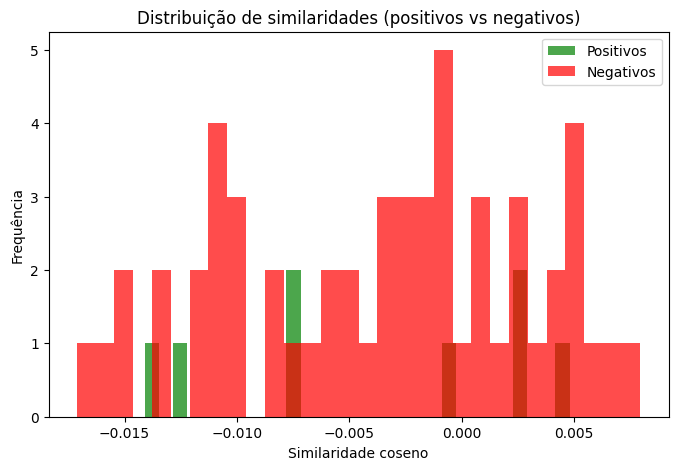

In [34]:
import matplotlib.pyplot as plt
import torch

# supondo que sims seja (num_images, num_texts)
# extraindo positivos e negativos
pos_sims = sims.diag()                          # diagonal -> imagem i com texto i
mask = ~torch.eye(sims.size(0), dtype=bool, device=sims.device)
neg_sims = sims[mask]                           # off-diagonal -> todos os pares incorretos

plt.figure(figsize=(8,5))

plt.hist(pos_sims.cpu().numpy(), bins=30, alpha=0.7, color="green", label="Positivos")
plt.hist(neg_sims.cpu().numpy(), bins=30, alpha=0.7, color="red", label="Negativos")

plt.xlabel("Similaridade coseno")
plt.ylabel("Frequência")
plt.title("Distribuição de similaridades (positivos vs negativos)")
plt.legend()
plt.show()


### Zero-shot classification

Como o modelo envolve similaridade entre texto e imagens, é difícil medir a qualidade de forma intuitiva. Uma forma de fazer isso é verificando a capacidade do modelo de ser aplicado em outras tarefas como classificação de imagens. Como o modelo não foi treinado para tal tarefa, isso é chamado de zero-shot accuracy.

Vamos implementar uma função simples de acurácia que verifica a capacidade do modelo em classificar as imagens nas classes gato e chachorro.

In [26]:
@torch.no_grad()
def zero_shot_classification(model, imgs, label_embeds):

    # Projeção das imagens
    image_embeds = model.project_images(imgs)
    # Similaridade entre cada imagem e as palavras 'cat' e 'dog'
    scores = torch.matmul(image_embeds, label_embeds.t())
    # Índice da classe mais provável
    predictions = scores.argmax(dim=1)

    return predictions

label_embeds = model.project_texts(["cat", "dog"])
predictions = zero_shot_classification(model, imgs, label_embeds)
print(predictions)

tensor([1, 1, 1, 1, 1, 0, 1, 1])


In [27]:
def accuracy(predictions, texts):
    """Mede a acurácia do modelo. Esta função estima a classe correta de cada imagem utilizando
    as respectivas legendas. O ideal seria utilizar as classes conhecidas do dataset Oxford Pets,
    mas isso adicionaria complexidade ao código."""
    
    targets = []
    for text in texts:
        if "cat" in text or "kitten" in text:
            target = 0
        elif "dog" in text or "puppy" in text:
            target = 1
        else:
            # Classe não reconhecida
            target = 2
        targets.append(target)
    targets = torch.tensor(targets, device=predictions.device)

    # Fração das imagens da classe gato (cachorro) que são mais similares à 
    # palavra 'cat' ('dog')
    mask = targets!=2
    targets = targets[mask]
    predictions = predictions[mask]
    acc = (predictions==targets).float().mean()

    return acc

accuracy(predictions, texts)

tensor(nan)